# Trajectory Recommendation using RankSVM and Structured Prediction

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#sec1)
  1. [Load Data](#sec1.1)
  1. [Utility Functions](#sec1.2)
1. [POI Ranking](#sec2)
  1. [POI Features for Ranking](#sec2.1)
  1. [Training DataFrame](#sec2.2)
  1. [Test DataFrame](#sec2.3)
  1. [Ranking POIs using rankSVM](#sec2.4)
1. [Structured Prediction Model Training and Evaluation](#sec3)
  1. [Features for Structured Prediction](#sec3.1)
  1. [Leave-one-out Evaluation](#sec3.2)
  1. [Discrepancy between Different BLAS Libraries](#sec3.3)
  1. [Hyperparameter Tuning](#sec3.4)

<a id='sec1'></a>

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns

from pystruct.models import ChainCRF
from pystruct.learners import OneSlackSSVM
from pystruct.learners import FrankWolfeSSVM

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-cikm16'
suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']

In [4]:
dat_ix = 0

In [5]:
noloop = True  # trajectories dataset with loop or not

In [6]:
datasettypes = ['all']

In [7]:
dstype = datasettypes[0]

Hyperparameters.

In [8]:
uspecific = False
KX = 100  # KX folds in user specific setting [100, 50, 20, 10, 8, 4, 2, 1]
kxstr = str(KX) + 'X-'

In [9]:
C = 2  # regularization parameter of SSVM
cstr = 'C' + str(C).replace('.', '_') + '-'

Method switches.

In [10]:
run_crf = True

In [11]:
fpoi = os.path.join(data_dir, 'poi-' + suffix[dat_ix] + '.csv')
if noloop == True:
    ftraj = os.path.join(data_dir, 'traj-noloop-' + dstype + '-' + suffix[dat_ix] + '.csv')
    if uspecific == True:
        frecdict_crf = os.path.join(data_dir, 'crf-noloop-' + dstype + '-specific-' +cstr +kxstr +suffix[dat_ix] +'.pkl')
    else:
        frecdict_crf = os.path.join(data_dir, 'crf-noloop-' + dstype + '-agnostic-' + cstr + suffix[dat_ix] + '.pkl')
else:
    ftraj = os.path.join(data_dir, 'traj-' + dstype + '-' + suffix[dat_ix] + '.csv')
    if uspecific == True:
        frecdict_crf = os.path.join(data_dir, 'crf-' + dstype + '-specific-' + cstr + kxstr + suffix[dat_ix] + '.pkl')
    else:
        frecdict_crf = os.path.join(data_dir, 'crf-' + dstype + '-agnostic-' + cstr + suffix[dat_ix] + '.pkl')

<a id='sec1.1'></a>

## 1.1 Load Data

In [12]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10297518@N00,1,20,1277719324,1277720832,6,1,1508
1,10307040@N08,2,6,1382608644,1382608644,1,4,0
2,10307040@N08,2,8,1382607812,1382607812,1,4,0
3,10307040@N08,2,21,1382607761,1382607774,2,4,13
4,10307040@N08,2,22,1382607879,1382608628,9,4,749


In [13]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Amusement,135.428938,34.654792
2,Amusement,135.430627,34.656145
3,Amusement,135.508558,34.652423
4,Amusement,135.433627,34.664758
5,Amusement,135.499894,34.703680


In [14]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
#assert(num_poi == poi_all.shape[0])
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Osak,27,1115,2.477778,450


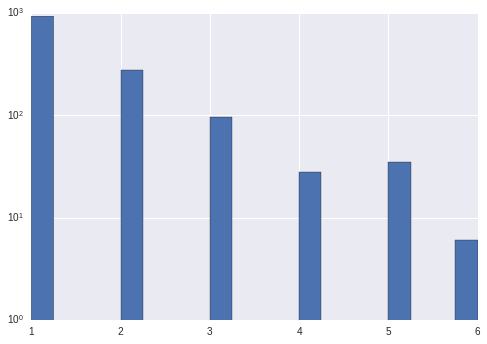

In [15]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')

Mapping trajectory to user.

In [16]:
traj_user = traj_all[['trajID', 'userID']].copy().groupby('trajID').first()
traj_user.head()

,userID
trajID,
1,10297518@N00
2,10307040@N08
3,10340578@N06
4,10340578@N06
5,10422365@N03


<a id='sec1.2'></a>

## 1.2 Utility Functions

Print computing progress.

In [17]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [18]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [19]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [20]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [21]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [22]:
poi_distmat = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [23]:
for ix in poi_all.index:
    poi_distmat.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [24]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [25]:
query_id_dict = dict()  # (start, end, length) --> qid

In [26]:
trajs = [extract_traj(tid, traj_all) for tid in trajid_set_all]
keys = [(t[0], t[-1], len(t)) for t in trajs if len(t) > 2]
cnt = 0
for key in keys:
    if key not in query_id_dict:   # (start, end, length) --> qid
        query_id_dict[key] = cnt
        cnt += 1

In [27]:
poi_info_ = calc_poi_info(trajid_set_all, traj_all, poi_all)
poi_info_.head()

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
1,3696.146067,89,Amusement,135.428938,34.654792,69
2,1532.204082,49,Amusement,135.430627,34.656145,39
3,4450.041667,24,Amusement,135.508558,34.652423,20
4,8226.625000,32,Amusement,135.433627,34.664758,27
5,1247.037383,107,Amusement,135.499894,34.703680,65


In [28]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(query_id_dict))

#traj in total: 1115
#traj (length > 2): 47
#query tuple: 43


<a id='sec2'></a>

# 2. POI Ranking

<a id='sec2.1'></a>

## 2.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: the total number of visit by all users
1. `avgDuration`: average POI visit duration
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `seqLen`: trajectory length (copy from query)
1. `diffPopStart`: difference in POI popularity from `startPOI`
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

In [29]:
df_columns = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration', \
              'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'trajLen', 'diffPopStart', \
              'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd']

~~Features aggregated from a number of trajectories:~~
~~1. Compute POI `popularity` and average visit `duration` using all trajectories from training and querying set,~~
~~1. Use the same features that computed above for the test set, except the distance based features.~~

<a id='sec2.2'></a>

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [30]:
def gen_train_subdf(poi_id, query_id_set, columns, poi_info, poi_distmat, query_id_rdict):
    df_ = pd.DataFrame(data=np.zeros((len(query_id_set), len(columns)), dtype=np.float), columns=columns)
    
    pop = poi_info.loc[poi_id, 'popularity']; nvisit = poi_info.loc[poi_id, 'nVisit']
    cat = poi_info.loc[poi_id, 'poiCat']; duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        
    return df_

In [31]:
def gen_train_df(trajid_list, columns, traj_all, poi_info, poi_distmat, query_id_dict, n_jobs=2):
    columns = columns.copy()
    train_trajs = [extract_traj(tid, traj_all) for tid in trajid_list]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs if len(t) > 2]))
    poi_set = sorted(set(poi_info.index.tolist()))
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, columns, poi_info, poi_distmat, query_id_rdict) \
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for t in train_trajs:
        if len(t) > 2:
            qid = query_id_dict[(t[0], t[-1], len(t))]
            for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
                df_.loc[(qid, poi), 'label'] += 1
    
    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

<a id='sec2.3'></a>

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [32]:
def gen_test_df(startPOI, endPOI, nPOI, columns, poi_info, poi_distmat, query_id_dict):
    columns = columns.copy()
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    poi_set = sorted(set(poi_info.index.tolist()))
    df_ = pd.DataFrame(data=np.zeros((len(poi_set), len(columns)), dtype= np.float), columns=columns)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_set[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiCat']; duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_all.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [33]:
def gen_data_str(df_, df_columns=df_columns):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

<a id='sec2.4'></a>

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [34]:
def softmax(x):
    expx = np.exp(x)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [35]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
    
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        #poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

<a id='sec3'></a>

# 3. Structured Prediction Model Training and Evaluation

<a id='sec3.1'></a>

## 3.1 Features for Structured Prediction

For a trajectory `[start, ..., end]`, the features used to train/test are 
1. ~~feature for POI `start` is a binary vector of size `total_number_of_POIs`, 
   with `1` at the location corresponds to POI `start` and `0` anywhere else, e.g. one hot encoding.~~
1. ~~feature for POI `end` is simliar, with `1` at the location corresponds to POI `end`.~~
1. features for other POIs in the trajectory are the ranking probabilities 
   (produced by rankSVM, transformed by softmax) of all POIs,
   i.e. features of different POIs in the middle (i.e. not the `start` or `end`) are the same.

<a id='sec3.2'></a>

## 3.2 Leave-one-out Evaluation

**NOTE**: [PyStruct](https://pystruct.github.io/) assumes that [label `y` is a discrete vector](https://pystruct.github.io/intro.html) and [pystruct.learners assume labels `y` are integers starting with `0`](https://github.com/pystruct/pystruct/issues/114), concretely,
- values in label vector $y$ should satisfy $y_i \in Y$, 
  where $Y$ is the **index** of a discrete value space, and the index starts at 0.
- label vector $y$ will be [transformed to one hot encoding (see function `joint_feature()`)](https://github.com/pystruct/pystruct/blob/master/pystruct/models/graph_crf.py).

For example, if labels in training set is `[[1, 2], [0, 4, 9]]`, 
then it will cause an index out of bounds error as pystruct did something like this,
1. construct an discrete value space: 
   - `set([1, 2] + [0, 4, 9]) -> {0, 1, 2, 4, 9}`
   - `size({0, 1, 2, 4, 9}) = 5`
1. convert labels using one hot encoding: 
   - label vector `[1, 2]` will be converted to a matrix of shape $2 \times 5$,
     with cells at `(0, 1), (1, 2)` set to `1` and others set to `0`.
   - label vector `[0, 4, 9]` will be converted to a matrix of shape $3 \times 5$,
     with cells at `(0, 0)`, `(1, 4)`, **`(2, 9)` INDEX_OUT_OF_BOUNDS** set to `1` and others set to `0`.

Train a [ChainCRF](https://pystruct.github.io/generated/pystruct.models.ChainCRF.html#pystruct.models.ChainCRF) using [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html#pystruct.learners.OneSlackSSVM).

In [40]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Build a mapping for POIs: *POI_ID $\to$ POI_INDEX* with POIs in trajectories of length $\ge 3$, also a map of the reverse direction.

In [41]:
#poi_set = set()
poi_id_dict  = dict()
poi_id_rdict = dict()
poi_cnt_dict = dict()
traj_dict = dict()

In [42]:
for tid in trajid_set_all:
    t = extract_traj(tid, traj_all)
    if len(t) < 3: continue
    #poi_set = poi_set | set(t)
    #poi_set = poi_set | set(t[1:-1])  # exclude the start and end POI
    assert(tid not in traj_dict)
    traj_dict[tid] = t
    for poi in t[1:-1]:
        if poi in poi_cnt_dict: 
            poi_cnt_dict[poi] += 1
        else:
            poi_cnt_dict[poi] = 1

In [43]:
#for ix, poi in enumerate(sorted(poi_set)): 
for ix, poi in enumerate(sorted(poi_cnt_dict.keys())): 
    poi_id_dict[poi] = ix
for k, v in poi_id_dict.items(): 
    poi_id_rdict[v] = k

In [44]:
assert(len(poi_id_dict) == len(poi_id_rdict) <= poi_info_all.shape[0])

In [45]:
poi_ix = [poi_id_rdict[x] for x in sorted(poi_id_rdict.keys())]  # POIs in ascending order of mapped IDs

In [46]:
F1_train_list = []
F1_test = []

In [47]:
if run_crf == True:
    recdict_crf = dict()
    cost = 1000
    cnt = 1
    for i in range(len(trajid_set_all)):
        t0 = time.time()
        tid = trajid_set_all[i]
        te = extract_traj(tid, traj_all)
        
        # trajectory too short
        if len(te) < 3: continue
            
        # TSP, generally an ILP very hard for solvers (GUROBI/CBC)
        if te[0] == te[-1]: continue

        if uspecific == True:
            user = traj_user.loc[tid, 'userID']
            trajid_set_user = traj_user[traj_user['userID'] == user].index.tolist()
            trajid_set_other = traj_user[traj_user['userID'] != user].index.tolist()
            assert(tid in trajid_set_user)
            trajid_set_add = [x for x in trajid_set_user if x != tid]
            trajid_list_train = trajid_set_other.copy()
            assert(KX > 0)
            for k in range(KX):
                trajid_list_train = trajid_list_train + trajid_set_add
        else:
            trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        # trajectory too long
        if len(te) > poi_info.shape[0]: continue
            
        # start/end is not in training set
        if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue
            
        # training set should contain all POIs
        goodTrainset = True
        for poi in te[1:-1]:
            assert(poi in poi_cnt_dict)
            if poi_cnt_dict[poi] == 1:  # POI exists in test set only
                goodTrainset = False
                break
        if goodTrainset == False: continue
        
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        t1 = time.time()
        
        # POI feature based ranking
        n_jobs = 4
        train_df = gen_train_df(trajid_list_train, df_columns, traj_all, poi_info, poi_distmat, query_id_dict, n_jobs)
        ranksvm = RankSVM(ranksvm_dir, useLinear=True)
        ranksvm.train(train_df, cost=cost)
        
        t2 = time.time()
            
        # generate training data
        X_train = []
        y_train = []
        train_set = sorted(set(traj_dict.keys()) - {tid})
        train_df_list = Parallel(n_jobs=n_jobs)(delayed(gen_test_df)\
                                 (traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x]), \
                                  df_columns, poi_info, poi_distmat, query_id_dict) for x in train_set)
        assert(len(train_set) == len(train_df_list))
        for j in range(len(train_set)):
            tr = traj_dict[train_set[j]]
            assert(len(tr) >= 3)
            tr_df = train_df_list[j]
            tr_rank_df = ranksvm.predict(tr_df)
            tr_rank_df.set_index('poiID', inplace=True)
            # (traj_length - 2) x (total number of POIs in trajectories with length >= 3)
            featuremat = np.tile(softmax(tr_rank_df.loc[poi_ix, 'rank']), (len(tr)-2, 1)) # without start and end
            X_train.append(featuremat)
            y_train.append(np.array([poi_id_dict[x] for x in tr[1:-1]]))
        
        t3 = time.time()        
                
        # train
        #crf = ChainCRF(directed=True)
        crf = ChainCRF()
        #maxIter = 10000  # default max_iter is 10000
        #ssvm = OneSlackSSVM(model=crf, C=C, max_iter=maxIter, n_jobs=4)
        ssvm = OneSlackSSVM(model=crf, C=C)
        ssvm.fit(X_train, y_train)
        
        t4 = time.time()
        
        # generate test data
        X_test = []
        te_df = gen_test_df(te[0], te[-1], len(te), df_columns, poi_info, poi_distmat, query_id_dict)
        te_rank_df = ranksvm.predict(te_df)
        te_rank_df.set_index('poiID', inplace=True)
        featuremat = np.tile(softmax(te_rank_df.loc[poi_ix, 'rank']), (len(te)-2, 1))
        #startfv = np.zeros(len(poi_ix), dtype=np.float); startfv[poi_id_dict[te[0]]] = 1
        #endfv = np.zeros(len(poi_ix), dtype=np.float); startfv[poi_id_dict[te[-1]]] = 1                 
        #X_test.append(np.vstack([startfv, featuremat, endfv]))
        X_test.append(featuremat)
        
        # test
        y_pred = ssvm.predict(X_test)
        rec = [te[0]] + [poi_id_rdict[x] for x in y_pred[0]] + [te[-1]]  # map POIs back
        F1_test.append(calc_F1(te, rec, noloop=True))
        
        # test on training set
        y_pred_train = ssvm.predict(X_train)
        F1_train = []
        assert(len(train_set) == len(y_pred_train))
        for j in range(len(train_set)):
            tr = traj_dict[train_set[j]]
            F1_train.append(calc_F1(tr, [tr[0]] + [poi_id_rdict[x] for x in y_pred_train[j]] + [tr[-1]], noloop=True))
        F1_train_list.append(F1_train)
        
        key = trajid_set_all[i]
        recdict_crf[key] = {'REAL':te, 'REC_CRF':rec} 
        
        t5 = time.time()
        
        print(' '*10, rec)
        print(' '*10, 'rank: %.1f sec, train_data: %.1f sec, train: %.1f sec, total: %.1f sec'%(t2-t1,t3-t2,t4-t3,t5-t0))
        print(' '*10, 'Train F1: %.3f %.3f, Test F1: %.3f' % (np.mean(F1_train), np.std(F1_train), F1_test[-1]))

[21, 8, 22, 6] #1 ->
           [21, 15, 22, 6]
           rank: 4.3 sec, train_data: 6.1 sec, train: 0.7 sec, total: 13.2 sec
           Train F1: 0.800 0.187, Test F1: 0.750
[21, 22, 3] #2 ->
           [21, 5, 3]
           rank: 4.1 sec, train_data: 5.8 sec, train: 0.7 sec, total: 12.7 sec
           Train F1: 0.827 0.184, Test F1: 0.667
[2, 1, 8] #3 ->
           [2, 1, 8]
           rank: 4.2 sec, train_data: 5.9 sec, train: 0.7 sec, total: 12.9 sec
           Train F1: 0.787 0.189, Test F1: 1.000
[20, 24, 21] #4 ->
           [20, 22, 21]
           rank: 4.2 sec, train_data: 5.9 sec, train: 0.7 sec, total: 12.8 sec
           Train F1: 0.804 0.171, Test F1: 0.667
[10, 3, 23, 20, 21] #5 ->
           [10, 8, 15, 12, 21]
           rank: 4.5 sec, train_data: 5.9 sec, train: 0.6 sec, total: 13.1 sec
           Train F1: 0.805 0.174, Test F1: 0.400
[6, 20, 5] #6 ->
           [6, 20, 5]
           rank: 4.2 sec, train_data: 5.9 sec, train: 0.7 sec, total: 12.9 sec
           Train 

In [48]:
if run_crf == True:
    pickle.dump(recdict_crf, open(frecdict_crf, 'bw'))

In [49]:
print('C = %.1f,' % C, suffix[dat_ix])

C = 2.0,  Osak


In [50]:
print('Train: %.3f, %.3f' % (np.mean([x for y in F1_train_list for x in y]), \
                             np.std([x for y in F1_train_list for x in y])))

Train: 0.803, 0.178


In [51]:
print('Test: %.3f, %.3f' % (np.mean(F1_test), np.std(F1_test)))

Test: 0.708, 0.155


In [52]:
F1 = [calc_F1(recdict_crf[key]['REAL'], recdict_crf[key]['REC_CRF'], noloop=True) for key in sorted(recdict_crf.keys())]

In [53]:
print(np.mean(F1), np.std(F1))

0.70753968254 0.155464927438


In [54]:
#recdict_crf0 = pickle.load(open(os.path.join(data_dir, 'crf-noloop-all-agnostic-Glas.0.pkl'), 'rb'))
#assert(len(recdict_crf0) == len(recdict_crf))
#for key in sorted(recdict_crf.keys()):
#    assert(key in recdict_crf0)
#    if np.all(np.array(recdict_crf[key]['REAL']) != np.array(recdict_crf0[key]['REAL'])):
#        print('REAL:', recdict_crf[key]['REAL'], recdict_crf0[key]['REAL'])
#    if np.all(np.array(recdict_crf[key]['REC_CRF']) != np.array(recdict_crf0[key]['REC_CRF'])):
#        print('REC:', recdict_crf[key]['REAL'], '->', recdict_crf[key]['REC_CRF'])
#        print('REC0:', recdict_crf0[key]['REAL'], '->', recdict_crf0[key]['REC_CRF'])

<a id='sec3.3'></a>

## 3.3 Discrepancy between Different BLAS Libraries

As Intel Math Kernel Library (MKL) is now [freely available in Anaconda](#https://docs.continuum.io/mkl-optimizations/index), I tried [CVXOPT v1.1.8](#http://cvxopt.org/) (used by [PyStruct v0.2.4](#https://pystruct.github.io/)) with both MKL and [OpenBLAS](#http://www.openblas.net/) and got some interesting findings.

The MKL version is 11.3.1 distributed by Anaconda, OpenBLAS version are 0.2.15 and 0.2.17.

Training/test mean F1-scores on Osaka dataset of trajectories without loops ($42$ trajectories in total).  
During the $6$ repeated runs (i.e., repeat the whole round of leave-one-out $6$ times), parameter $C$ of the [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html) was set to $2$, and default values were used for all other parameters.

**MKL v11.3.1** (latest release from Anaconda)

On server `braun`.

In [93]:
train_F1_mkl = [0.799, 0.802, 0.803, 0.804, 0.804, 0.803]
test_F1_mkl = [0.705, 0.707, 0.697, 0.713, 0.700, 0.699]

On machine `localPC`.

In [94]:
train_F1_mkll = [0.803, 0.803, 0.803, 0.803, 0.803, 0.803]
test_F1_mkll = [0.708, 0.708, 0.708, 0.708, 0.708, 0.708]

**OpenBLAS v0.2.15**  (default version of OpenBLAS on Debian 9)

On server `braun`.

In [95]:
train_F1_openblas5 = [0.806, 0.806, 0.806, 0.806, 0.806, 0.806]
test_F1_openblas5 = [0.711, 0.711, 0.711, 0.711, 0.711, 0.711]

On machine `localPC`.

In [96]:
train_F1_openblas5l = [0.802, 0.802, 0.802, 0.802, 0.802, 0.802]
test_F1_openblas5l = [0.728, 0.728, 0.728, 0.728, 0.728, 0.728]

**OpenBLAS v0.2.17** (latest release of OpenBLAS)

On server `braun`.

In [97]:
train_F1_openblas7 = [0.806, 0.806, 0.806, 0.806, 0.806, 0.806]
test_F1_openblas7 = [0.711, 0.711, 0.711, 0.711, 0.711, 0.711]

On machine `localPC`.

In [98]:
train_F1_openblas7l = [0.804, 0.804, 0.804, 0.804, 0.804, 0.804]
test_F1_openblas7l = [0.700, 0.700, 0.700, 0.700, 0.700, 0.700]

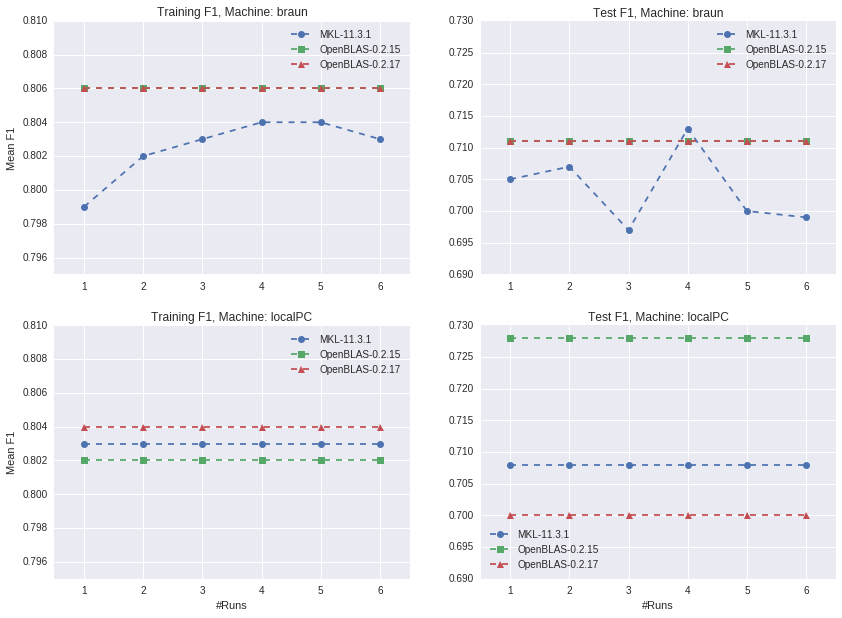

In [105]:
plt.figure(figsize=[14, 10])
plt.subplot(2, 2, 1)
plt.title('Training F1, Machine: braun')
plt.plot(np.arange(1, len(train_F1_mkl)+1), train_F1_mkl, marker='o', ls='--', label='MKL-11.3.1')
plt.plot(np.arange(1, len(train_F1_openblas5)+1), train_F1_openblas5, marker='s', ls='--', label='OpenBLAS-0.2.15')
plt.plot(np.arange(1, len(train_F1_openblas7)+1), train_F1_openblas7, marker='^', ls='--', label='OpenBLAS-0.2.17')
plt.xlim([0.5, 6.5])
plt.ylim([0.795, 0.81])
plt.ylabel('Mean F1')
plt.legend(loc='best')

plt.subplot(2, 2, 2)
plt.title('Test F1, Machine: braun')
plt.plot(np.arange(1, len(test_F1_mkl)+1), test_F1_mkl, marker='o', ls='--', label='MKL-11.3.1')
plt.plot(np.arange(1, len(test_F1_openblas5)+1), test_F1_openblas5, marker='s', ls='--', label='OpenBLAS-0.2.15')
plt.plot(np.arange(1, len(test_F1_openblas7)+1), test_F1_openblas7, marker='^', ls='--', label='OpenBLAS-0.2.17')
plt.xlim([0.5, 6.5])
plt.ylim([0.69, 0.73])
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title('Training F1, Machine: localPC')
plt.plot(np.arange(1, len(train_F1_mkll)+1), train_F1_mkll, marker='o', ls='--', label='MKL-11.3.1')
plt.plot(np.arange(1, len(train_F1_openblas5l)+1), train_F1_openblas5l, marker='s', ls='--', label='OpenBLAS-0.2.15')
plt.plot(np.arange(1, len(train_F1_openblas7l)+1), train_F1_openblas7l, marker='^', ls='--', label='OpenBLAS-0.2.17')
plt.xlim([0.5, 6.5])
plt.ylim([0.795, 0.81])
plt.xlabel('#Runs')
plt.ylabel('Mean F1')
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title('Test F1, Machine: localPC')
plt.plot(np.arange(1, len(test_F1_mkll)+1), test_F1_mkll, marker='o', ls='--', label='MKL-11.3.1')
plt.plot(np.arange(1, len(test_F1_openblas5l)+1), test_F1_openblas5l, marker='s', ls='--', label='OpenBLAS-0.2.15')
plt.plot(np.arange(1, len(test_F1_openblas7l)+1), test_F1_openblas7l, marker='^', ls='--', label='OpenBLAS-0.2.17')
plt.xlim([0.5, 6.5])
plt.ylim([0.69, 0.73])
plt.xlabel('#Runs')
plt.legend(loc='best')

<a id='sec3.4'></a>

## 3.4 Hyperparameter Tuning

Tuning the regularization parameter $C$ in [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html).

NOTE: Suppose there were $N$ trajectories in total, training F1 was the mean of all F1-scores during all iterations of leave-one-out, i.e., $(N-1)*N$ F1-scores. Test F1 was the mean of all F1-score during all iterations of leave-one-out, i.e., $N$ F1-scores.

Datasets of trajectories without loops, based on running results on `localPC` with OpenBLAS v0.2.15.

<table>
<tr><td rowspan='2'><b>C</b></td><td colspan='2'><b>Edinburgh</b></td><td colspan='2'><b>Glasgow</b></td>
                                 <td colspan='2'><b>Osaka</b></td><td colspan='2'><b>Toronto</b></td></tr>
<tr><td><b>Train_F1</b></td><td><b>Test_F1</b></td><td><b>Train_F1</b></td><td><b>Test_F1</b></td>
    <td><b>Train_F1</b></td><td><b>Test_F1</b></td><td><b>Train_F1</b></td><td><b>Test_F1</b></td></tr>
<tr><td>0.1</td><td> </td><td> </td><td>0.732</td><td>0.708</td><td>0.720</td><td>0.646</td><td> </td><td> </td></tr>
<tr><td>0.3</td><td> </td><td> </td><td>0.756</td><td>0.704</td><td>0.752</td><td>0.687</td><td> </td><td> </td></tr>
<tr><td>1.0</td><td> </td><td> </td><td>0.776</td><td>0.740</td><td>0.787</td><td>0.705</td><td> </td><td> </td></tr>
<tr><td>2.0</td><td> </td><td> </td><td>0.781</td><td>0.730</td><td>0.802</td><td>0.728</td><td> </td><td> </td></tr>
<tr><td>3.0</td><td> </td><td> </td><td>0.793</td><td>0.732</td><td>0.807</td><td>0.698</td><td> </td><td> </td></tr>
<tr><td>10 </td><td> </td><td> </td><td> </td><td> </td><td>0.818</td><td>0.683</td><td> </td><td> </td></tr>
<tr><td>30 </td><td> </td><td> </td><td> </td><td> </td><td>0.827</td><td>0.695</td><td> </td><td> </td></tr>
<tr><td>100</td><td> </td><td> </td><td> </td><td> </td><td>0.838</td><td>0.690</td><td> </td><td> </td></tr>
<tr><td>300</td><td> </td><td> </td><td> </td><td> </td><td>0.841</td><td>0.690</td><td> </td><td> </td></tr>
<tr><td>1000</td><td> </td><td> </td><td> </td><td> </td><td> </td><td> </td><td> </td><td> </td></tr>
</table>